## Vision: An online platform for product marketing professionals to gather the market price of products similar to what they are planning to release
### Step 1: Prediction of women's shoe price

**Background:** This dataset has about 10,000 records of woman's shoes and its prices.
    
**Data Source:** https://data.world/datafiniti/womens-shoe-prices

**Objective:** To predict the women's shoe price from the brand, model and other specifics
    
**Performance metric for machine learning model:** <Br>
Primary: Mean Squared Error <Br>
Secondary: Mean Absolute Error

#### Outline

1. Uploading data and storing it in a SQLite database
2. Split data into train and test
3. EDA on train data <br>
**4. Feature selection on train data** <br>
**5. Feature Engineering on train data** <br>
**6. Pipeline creation for modelling** <br>
**7. Modelling of data** <br>
8. Final model selection <br>
9. Next Steps<br>

In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 
import re
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor

### 1. Uploading data and storing it in a database

- The source destination has 3 files 
Reading data from CSV file to SQL database

In [301]:
file1 = pd.read_csv(r"7003_1.csv")
file2 = pd.read_csv(r"Datafiniti_Womens_Shoes_Jun19.csv")
file3 = pd.read_csv(r"Datafiniti_Womens_Shoes.csv")

In [302]:
file1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19045 entries, 0 to 19044
Data columns (total 47 columns):
id                     19045 non-null object
asins                  2208 non-null object
brand                  18412 non-null object
categories             19045 non-null object
colors                 11889 non-null object
count                  0 non-null float64
dateAdded              19045 non-null object
dateUpdated            19045 non-null object
descriptions           10780 non-null object
dimension              2418 non-null object
ean                    9816 non-null float64
features               14108 non-null object
flavors                0 non-null float64
imageURLs              17840 non-null object
isbn                   0 non-null float64
keys                   19045 non-null object
manufacturer           8656 non-null object
manufacturerNumber     15903 non-null object
merchants              13688 non-null object
name                   19045 non-null object
pri

In [303]:
file2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
id                     10000 non-null object
dateAdded              10000 non-null object
dateUpdated            10000 non-null object
asins                  5 non-null object
brand                  10000 non-null object
categories             10000 non-null object
primaryCategories      10000 non-null object
colors                 10000 non-null object
dimension              465 non-null object
ean / upc              10000 non-null int64
imageURLs              2643 non-null object
keys                   10000 non-null object
manufacturer           1362 non-null object
manufacturerNumber     1431 non-null object
name                   10000 non-null object
prices.amountMax       10000 non-null float64
prices.amountMin       10000 non-null float64
prices.availability    10000 non-null bool
prices.color           10000 non-null object
prices.condition       0 non-null float64
price

In [304]:
file3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
id                     10000 non-null object
dateAdded              10000 non-null object
dateUpdated            10000 non-null object
asins                  3 non-null object
brand                  10000 non-null object
categories             10000 non-null object
primaryCategories      10000 non-null object
colors                 2631 non-null object
dimension              117 non-null object
ean                    671 non-null float64
imageURLs              10000 non-null object
keys                   10000 non-null object
manufacturer           527 non-null object
manufacturerNumber     2482 non-null object
name                   10000 non-null object
prices.amountMax       10000 non-null float64
prices.amountMin       10000 non-null float64
prices.availability    434 non-null object
prices.color           10000 non-null object
prices.condition       438 non-null object
price

In [305]:
file1_cols = [i for i in file1.columns]
file2_cols = [i for i in file2.columns]
file3_cols = [i for i in file3.columns]

In [306]:
print("Total number of columns in File 1: ", len(file1_cols))
print("Total number of columns in File 2: ", len(file2_cols))
print("Total number of columns in File 3: ", len(file3_cols))

Total number of columns in File 1:  47
Total number of columns in File 2:  32
Total number of columns in File 3:  34


File 3 is updated file of file 2. We will use file 3 for our analysis

In [307]:
file3.sample(5).loc[:,'prices.color':]

,prices.color,prices.condition,prices.currency,prices.dateAdded,prices.dateSeen,prices.isSale,prices.merchant,prices.offer,prices.returnPolicy,prices.shipping,prices.size,prices.sourceURLs,sizes,sourceURLs,upc,weight
8133,Gray Hot Punch,NaN,USD,2018-01-11T00:01:47Z,"2018-01-05T11:03:00.000Z,2018-01-04T08:22:00.0...",False,NaN,NaN,NaN,NaN,9.5,https://www.kohls.com/product/prd-2734966/nike...,"10.5 WIDE,7 WIDE,7.5 WIDE,8 WIDE,8.5 WIDE,9 WI...",https://www.kohls.com/product/prd-2734966/nike...,"884500153103,884500152984,884500152991,8845001...",NaN
545,Black,NaN,USD,2018-01-10T19:52:24Z,"2018-01-09T13:48:00.000Z,2017-12-07T10:21:00.0...",False,NaN,NaN,NaN,NaN,9 MED,https://www.kohls.com/product/prd-2962763/dolc...,"6 MED,6.5 MED,7 MED,7.5 MED,8 MED,8.5 MED,9 ME...",https://www.kohls.com/product/prd-2962763/dolc...,"190008085298,190008085151,190008085014,1900080...",NaN
4308,Pewter,NaN,USD,2017-12-31T00:00:55Z,2017-12-25T08:50:00.000Z,False,NaN,NaN,NaN,NaN,8 WIDE,https://www.kohls.com/product/prd-2866828/life...,"5 MED,5.5 MED,6 MED,6.5 MED,7 MED,7.5 MED,8 ME...",https://www.kohls.com/product/prd-2866828/life...,"727684023735,727684025272,727684023728,7276840...",NaN
6141,Nude,NaN,USD,2017-11-29T13:52:09Z,"2017-11-05T14:55:00.000Z,2017-11-03T11:39:00.0...",False,NaN,NaN,NaN,NaN,11,https://www.kohls.com/product/prd-2538791/jour...,"6,6.5,7,7.5,8,8.5,9,10,11",https://www.kohls.com/product/prd-2538791/jour...,"870251586451,870251586635,870251586543,8702515...",NaN
3635,Black,NaN,USD,2017-12-19T11:46:48Z,"2017-11-26T12:39:00.000Z,2017-11-25T09:45:00.0...",False,NaN,NaN,NaN,NaN,9 MED,https://www.kohls.com/product/prd-2866127/life...,"5 MED,5.5 MED,6 MED,6.5 MED,7 MED,7.5 MED,8 ME...",https://www.kohls.com/product/prd-2866127/life...,"727682429676,727682429430,727682206277,7276824...",NaN


Let us explore file 3 first as it has information more specific to women's shoes

Create a SQLlite database and create a table named shoes that contains the contents from file3

In [308]:
# create connection to database
connection = sqlite3.connect("womensshoes.db") 
# cursor  
crsr = connection.cursor() 

file3.to_sql('shoes', connection, if_exists='replace', index = False) 

In [460]:
df = pd.read_sql_query("select * from shoes;", connection)
df.columns

Index(['id', 'dateAdded', 'dateUpdated', 'asins', 'brand', 'categories',
       'primaryCategories', 'colors', 'dimension', 'ean', 'imageURLs', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'prices.amountMax',
       'prices.amountMin', 'prices.availability', 'prices.color',
       'prices.condition', 'prices.currency', 'prices.dateAdded',
       'prices.dateSeen', 'prices.isSale', 'prices.merchant', 'prices.offer',
       'prices.returnPolicy', 'prices.shipping', 'prices.size',
       'prices.sourceURLs', 'sizes', 'sourceURLs', 'upc', 'weight'],
      dtype='object')

The dataset contains maximum and minimum price for shoes. Let us take the average of these prices and use it as target feature

In [461]:
df['average_price']= (df['prices.amountMax'] + df['prices.amountMin'])/2
df.head(2)

,id,dateAdded,dateUpdated,asins,brand,categories,primaryCategories,colors,dimension,ean,...,prices.offer,prices.returnPolicy,prices.shipping,prices.size,prices.sourceURLs,sizes,sourceURLs,upc,weight,average_price
0,AVpfEf_hLJeJML431ueH,2015-05-04T12:13:08Z,2018-01-29T04:38:43Z,None,Naturalizer,"Clothing,Shoes,Women's Shoes,All Women's Shoes...",Shoes,"Silver,Cream Watercolor Floral",None,NaN,...,None,None,None,S,https://www.overstock.com/Clothing-Shoes/Women...,"6W,9W,7.5W,12W,8.5M,9N,9M,9.5M,10.5M,10W,8.5W,...",https://www.walmart.com/ip/Naturalizer-Danya-W...,017136472311,None,55.990
1,AVpi74XfLJeJML43qZAc,2017-01-27T01:23:39Z,2018-01-03T05:21:54Z,None,MUK LUKS,"Clothing,Shoes,Women's Shoes,Women's Casual Sh...",Shoes,Grey,None,3.397705e+10,...,None,None,Standard,6,https://www.walmart.com/ip/MUK-LUKS-Womens-Jan...,"10,7,6,9,8",https://www.walmart.com/ip/MUK-LUKS-Womens-Jan...,033977045743,None,41.125


### 2. Split data into train and test 

In [462]:
X = df[df.columns[:-1]]
y = df.average_price

In [463]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.7, test_size=0.3, random_state = 42)
print(X_train.shape)

(7000, 34)


In [464]:
X_train_backup = X_train.copy()

### 3. Exploratory Data Analysis

In [465]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 34 columns):
id                     7000 non-null object
dateAdded              7000 non-null object
dateUpdated            7000 non-null object
asins                  2 non-null object
brand                  7000 non-null object
categories             7000 non-null object
primaryCategories      7000 non-null object
colors                 1874 non-null object
dimension              81 non-null object
ean                    475 non-null float64
imageURLs              7000 non-null object
keys                   7000 non-null object
manufacturer           367 non-null object
manufacturerNumber     1762 non-null object
name                   7000 non-null object
prices.amountMax       7000 non-null float64
prices.amountMin       7000 non-null float64
prices.availability    319 non-null object
prices.color           7000 non-null object
prices.condition       321 non-null object
prices.currency 

Observation:
    - Most of the features (>85%) are object or categorical type
    - Only 4 numerical features
    - Feature prices.returnPolicy does not contain any information and it can be removed
    - Feature asins has only 2 non-null values. This feature can also be removed
    - Date columns are present which can be converted to pandas timestamp type

Data Cleaning and Feature Selection

In [466]:
# Features to remove
#features_remove = {'prices.returnPolicy', 'asins'}

In [467]:
##Identify features with more than 90% of data missing
pct_missing_greater_90 = X_train.isnull().sum()/X_train.shape[0] 
pct_missing_greater_90 = pct_missing[pct_missing > .9]
pct_missing_greater_90

asins                  0.999714
dimension              0.988429
ean                    0.932143
manufacturer           0.947571
prices.availability    0.954429
prices.condition       0.954143
prices.merchant        0.954429
prices.offer           0.986286
prices.returnPolicy    1.000000
prices.shipping        0.956286
weight                 0.968571
dtype: float64

In [468]:
X_train[['prices.merchant', 'prices.offer', 'manufacturer']]

,prices.merchant,prices.offer,manufacturer
9069,None,None,None
2603,None,None,None
7738,None,None,None
1579,None,None,None
5058,None,None,None
...,...,...,...
5734,None,None,Spring Footwear
5191,None,None,None
5390,None,None,None
860,None,None,None


In [469]:
features_remove = pct_missing_greater_90[~pct_missing_greater_90.index.isin(['manufacturer', 
                                                           'prices.offer', 
                                                           'prices.merchant'])].index.to_list()
features_remove

['asins',
 'dimension',
 'ean',
 'prices.availability',
 'prices.condition',
 'prices.returnPolicy',
 'prices.shipping',
 'weight']

- All these features except the following can be eliminated: 'Manufacturer', 'prices.offer', 'prices.merchant' . Further analysis will be performed on these features

In [470]:
## Identify features with low variance
X_train[~X_train.isin(features_remove)].var()

ean                 3.438696e+22
prices.amountMax    3.772647e+02
prices.amountMin    4.404210e+02
prices.isSale       1.795391e-02
dtype: float64

The variance of "prices.isSale" is <0.02. Whether the product is on sale or not can determine its price . So lets study this feature further before eliminating it. 

In [471]:
# Variance for categorical values
X_train.nunique()[X_train.nunique() < 10]

asins                  1
primaryCategories      2
prices.availability    3
prices.condition       2
prices.currency        1
prices.isSale          2
prices.merchant        9
prices.returnPolicy    0
prices.shipping        7
dtype: int64

In [472]:
print("What are the 2 unique values present in primary \
      categories feature?",X_train.primaryCategories.unique())
print("What is the unique values present in prices.currency?",X_train['prices.currency'].unique())

What are the 2 unique values present in primary       categories feature? ['Shoes,Shoes' 'Shoes']
What is the unique values present in prices.currency? ['USD']


- primaryCategories contains only one string - Shoes - 0 variance - it can be eliminated
- All the prices are in USD currency - 0 variance - prices.currency can be leminated

In [473]:
#features_remove.update('primaryCategories', 'prices.currency')
features_remove.extend(['primaryCategories', 'prices.currency'])
features_remove

['asins',
 'dimension',
 'ean',
 'prices.availability',
 'prices.condition',
 'prices.returnPolicy',
 'prices.shipping',
 'weight',
 'primaryCategories',
 'prices.currency']

Identifying features that are not relevant to price prediction

In [474]:
X_train.columns[~X_train.columns.isin(features_remove)]

Index(['id', 'dateAdded', 'dateUpdated', 'brand', 'categories', 'colors',
       'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'name',
       'prices.amountMax', 'prices.amountMin', 'prices.color',
       'prices.dateAdded', 'prices.dateSeen', 'prices.isSale',
       'prices.merchant', 'prices.offer', 'prices.size', 'prices.sourceURLs',
       'sizes', 'sourceURLs', 'upc'],
      dtype='object')

These features may not be relevant for predicting the shoe price. Let us explore them <br>

1.  Date features 
        From datainfiniti product schema,<br>
        **dateAdded:** The date this product was first added to datainfiniti's product database. <br>
        **dateUpdated:** The most recent date this product was updated or seen by our system.<br>
        **prices.dateAdded:** No information<br>
        **prices.dateSeen:** A list of dates when this price was seen.<br>

       For predicting average price of shoes, these data columns are not necessary. But we can explore this to understand the time frame during which these price information was collected. 

2. Links
        **imageURLs** <br>
        **prices.sourceURLs** <br>
        **sourceURLs** <br>
3. UPC
4. id
5. keys


#### 1.  Date Features

In [475]:
## Let us explore the date features
X_train[['dateAdded', 'dateUpdated', 'prices.dateAdded', 'prices.dateSeen', 'prices.amountMax',
       'prices.amountMin']]

,dateAdded,dateUpdated,prices.dateAdded,prices.dateSeen,prices.amountMax,prices.amountMin
9069,2017-11-05T03:20:35Z,2018-01-11T01:19:21Z,2018-01-11T01:19:21Z,"2018-01-05T12:36:00.000Z,2018-01-09T13:31:00.0...",129.99,129.99
2603,2017-11-24T12:25:07Z,2018-02-01T07:35:56Z,2017-11-24T12:25:07Z,2017-11-12T09:36:00.000Z,69.99,39.99
7738,2017-11-20T21:09:48Z,2018-02-01T07:35:44Z,2018-01-02T17:29:14Z,"2017-12-19T11:52:00.000Z,2017-12-15T13:59:00.0...",59.99,42.49
1579,2017-11-17T15:56:59Z,2018-01-21T03:17:22Z,2017-11-25T22:28:55Z,"2017-11-02T08:25:00.000Z,2017-11-03T09:30:00.000Z",59.99,27.99
5058,2017-11-10T19:33:26Z,2018-01-29T04:27:28Z,2017-12-31T11:44:39Z,"2017-12-25T16:57:00.000Z,2017-12-04T13:58:00.0...",89.99,52.49
...,...,...,...,...,...,...
5734,2015-08-14T18:09:12Z,2018-02-01T07:33:04Z,2018-02-01T07:33:04Z,"2018-01-16T08:27:00.000Z,2018-01-17T14:44:00.0...",79.99,79.99
5191,2017-11-10T19:33:46Z,2018-01-21T02:19:53Z,2017-12-31T04:46:33Z,"2017-12-04T15:29:00.000Z,2017-12-03T06:44:00.0...",89.00,52.49
5390,2017-11-10T19:33:19Z,2018-02-13T21:53:04Z,2018-01-11T00:03:43Z,"2018-01-05T11:40:00.000Z,2018-01-09T14:10:00.0...",119.00,119.00
860,2017-09-12T03:29:25Z,2018-02-01T07:34:14Z,2018-02-01T07:34:14Z,"2018-01-16T09:58:00.000Z,2018-01-15T11:52:00.0...",54.99,54.99


In [476]:
X_train[['dateAdded', 'dateUpdated', 'prices.dateAdded']] = X_train[['dateAdded', 'dateUpdated', 'prices.dateAdded']].apply(pd.to_datetime)

In [477]:
X_train[['dateAdded', 'dateUpdated', 'prices.dateAdded']].describe()

,dateAdded,dateUpdated,prices.dateAdded
count,7000,7000,6449
unique,416,462,1743
top,2017-11-10 19:33:19+00:00,2018-02-01 07:36:18+00:00,2018-02-01 07:32:58+00:00
freq,181,165,58
first,2015-07-20 22:46:58+00:00,2018-01-01 05:51:15+00:00,2015-11-30 01:47:56+00:00
last,2018-05-21 13:17:40+00:00,2018-10-23 21:26:11+00:00,2018-02-14 20:58:11+00:00


The data in this dataset were collected from May 2015  - October 2018. 

In [478]:
features_remove.extend(['dateAdded', 'dateUpdated', 'prices.dateAdded', 'prices.dateSeen', 'prices.amountMax',
       'prices.amountMin'])

#### 2. Links
Let's look at the different links. We are not going to use image for our predition and thus, image url can de removed. 

In [479]:
# Are sourceurl and prices.sourceurls the same?
url = X_train[X_train.columns[X_train.columns.str.contains("URL")]]
url

,imageURLs,prices.sourceURLs,sourceURLs
9069,https://media.kohlsimg.com/is/image/kohls/2480...,https://www.kohls.com/product/prd-2480285/asic...,https://www.kohls.com/product/prd-2480285/asic...
2603,https://media.kohlsimg.com/is/image/kohls/2908...,https://www.kohls.com/product/prd-2908377/so-w...,https://www.kohls.com/product/prd-2908377/so-w...
7738,https://media.kohlsimg.com/is/image/kohls/2948...,https://www.kohls.com/product/prd-2948334/jour...,https://www.kohls.com/product/prd-2948334/jour...
1579,https://media.kohlsimg.com/is/image/kohls/2532...,https://www.kohls.com/product/prd-2532138/crof...,https://www.kohls.com/product/prd-2532138/crof...
5058,https://media.kohlsimg.com/is/image/kohls/2923...,https://www.kohls.com/product/prd-2923522/a2-b...,https://www.kohls.com/product/prd-2923522/a2-b...
...,...,...,...
5734,https://media.kohlsimg.com/is/image/kohls/2769...,https://www.kohls.com/product/prd-2769027/spri...,https://www.kohls.com/product/prd-2769027/spri...
5191,https://media.kohlsimg.com/is/image/kohls/2811...,https://www.kohls.com/product/prd-2811198/styl...,https://www.kohls.com/product/prd-2811198/styl...
5390,https://media.kohlsimg.com/is/image/kohls/2584...,https://www.kohls.com/product/prd-2584698/styl...,https://www.kohls.com/product/prd-2584698/styl...
860,https://media.kohlsimg.com/is/image/kohls/2966...,https://www.kohls.com/product/prd-2966724/adid...,https://www.kohls.com/product/prd-2966724/adid...


In [480]:
print("sourceURLs and prices.sourceURLs are the same:", (url.sourceURLs == url['prices.sourceURLs']).all())

sourceURLs and prices.sourceURLs are the same: False


In [481]:
## Source URL contains the seller company name. This will be useful information for predicting the 
## shoe price. Let's check if this is capture already in otehr features 
X_train[['brand', 'manufacturer', 'name', 'prices.merchant', 'sourceURLs']]

,brand,manufacturer,name,prices.merchant,sourceURLs
9069,asics,None,ASICS GEL Quantum 180 2 Women's Running Shoes,None,https://www.kohls.com/product/prd-2480285/asic...
2603,so,None,SO Follow Women's Ankle Boots,None,https://www.kohls.com/product/prd-2908377/so-w...
7738,journee collection,None,Journee Collection Marlee Women's Pointed Flats,None,https://www.kohls.com/product/prd-2948334/jour...
1579,croft barrow,None,Croft Barrow Women's Ortholite Quilted Ballet ...,None,https://www.kohls.com/product/prd-2532138/crof...
5058,a2 by aerosoles,None,A2 by Aerosoles Gravity Women's Ankle Boots,None,https://www.kohls.com/product/prd-2923522/a2-b...
...,...,...,...,...,...
5734,spring step,Spring Footwear,Spring Step Happy Women's Clogs,None,https://www.kohls.com/product/prd-2769027/spri...
5191,style charles by charles david,None,Style Charles by Charles David Laura Women's W...,None,https://www.kohls.com/product/prd-2811198/styl...
5390,style charles by charles david,None,Style Charles by Charles David Groove Women's ...,None,https://www.kohls.com/product/prd-2584698/styl...
860,adidas,None,adidas NEO Courtset Women's Suede Sneakers,None,https://www.kohls.com/product/prd-2966724/adid...


In [482]:
# A list of merchants selling this product. These are typically third-party merchants found on
#e-commerce websites.
X_train[~X_train['prices.merchant'].isnull()]
X_train['prices.merchant'].unique()

array([None, 'Backcountry.com', 'Walmart.com',
       'DAILYWEAR  SPORTSWEAR CORP.', 'AmazingBasics', 'Slippers Dot Com',
       'Overstock.com', 'UnbeatableSale', 'Tasharina Corp', 'Shoebuy.com'],
      dtype=object)

Merchant contains the information about seller company. We know from before that merchnat does 
not contain all the information. May be we can use it for imputing the seller's name?

In [483]:
X_train[X_train['prices.merchant'] ==  'DAILYWEAR  SPORTSWEAR CORP.']

,id,dateAdded,dateUpdated,asins,brand,categories,primaryCategories,colors,dimension,ean,...,prices.merchant,prices.offer,prices.returnPolicy,prices.shipping,prices.size,prices.sourceURLs,sizes,sourceURLs,upc,weight
142,AVph34uzilAPnD_x-STz,2017-01-23 05:30:38+00:00,2018-01-30 06:16:48+00:00,None,Victoria K.,"Clothing,Shoes,Women's Shoes,All Women's Shoes",Shoes,"Black,Red",None,6.635160e+11,...,DAILYWEAR SPORTSWEAR CORP.,None,None,Value,6,https://www.walmart.com/ip/Victoria-K-Women-s-...,"10,7,6,9,8",https://www.walmart.com/ip/Victoria-K-Women-s-...,663516000000,None


Are price.sourceurl and source url the same?

In [484]:
X_train.sourceURLs == X_train['prices.sourceURLs']
psl = X_train['prices.sourceURLs'].str.extract(r'(.+?(?=.com))')
surl = X_train['sourceURLs'].str.extract(r'(.+?(?=.com))')
pd.concat([surl,psl], axis =1)[~(surl[0] == psl[0])]

,0,0
8966,http://www.walmart,https://www.kohls
122,https://www.walmart,https://www.kohls
3445,https://www.walmart,https://www.kohls
8409,https://www.walmart,https://www.kohls
3438,https://www.walmart,https://www.kohls
...,...,...
3748,https://www.walmart,https://www.kohls
64,https://www.walmart,https://www.kohls
8571,https://www.walmart,https://www.kohls
8529,https://www.walmart,https://www.kohls


**Price source url:** Products sold by walmart.com, third party in e-commerce site <br>
**sourceURLs:** A list of URLs used to generate data for this product. <br>

-- Source url and price source url are not the same. <br>
-- Since we obtain price from price source url, we can use company from that field as merchant if merchant is not found.<br>
-- After the above steps, all the urls can be eliminated.<br>

In [485]:
features_remove.extend(['prices.sourceURLs', 'sourceURLs', 'imageURLs' ])

#### 3. UPC

 Universal Product Code (UPC) These are unique barcode number specific to product. More than one upc for an observation idicates the variation of the product. Let us remove it for now.

id
keys: These are keys for data infiniti internal usage and can be removed

In [486]:
X_train.groupby('upc')[['name', 'prices.size']].count()

X_train[X_train.upc == "017136923998"]


,id,dateAdded,dateUpdated,asins,brand,categories,primaryCategories,colors,dimension,ean,...,prices.merchant,prices.offer,prices.returnPolicy,prices.shipping,prices.size,prices.sourceURLs,sizes,sourceURLs,upc,weight


In [487]:
X_train['keys']

9069    889436945259,asicsgelquantum1802womensrunnings...
2603    685393075035,sofollowwomensankleboots/76510951...
7738    870251663947,870251663824,870251663701,8702516...
1579    400616766145,400278273746,croftbarrowwomensort...
5058    737280674279,737280674675,737280675467,7372806...
                              ...                        
5734    840233267050,springstephappywomensclogs/773661...
5191    stylecharlesbycharlesdavidlaurawomenswedgesand...
5390    740112509748,740112523171,stylecharlesbycharle...
860     adidasneocourtsetwomenssuedesneakers/52814332,...
7270    870251651241,870251651562,870251651364,8702516...
Name: keys, Length: 7000, dtype: object

Let us study the 'id' feature. Is id feature related to 'name' feature?


In [488]:
print("Number of unique id:", X_train.id.nunique())
print("Number of unique models:",X_train.name.nunique())
print("Number of unique brands:",X_train.brand.nunique())

Number of unique id: 611
Number of unique models: 610
Number of unique brands: 119


In [489]:
X_train.groupby('name')['id'].nunique().sort_values(ascending = False)

name
Brinley Co Womens Mary Jane Patent Leather Pumps                                             2
sugar Raffle Women's Waterproof Rain Boots                                                   1
Journee Collection Cortni Women's Pointed-Toe Flats                                          1
Journee Collection Dream Women's High Heels                                                  1
Journee Collection Dorsy Women's Pointed-Toe Flats                                           1
                                                                                            ..
New Balance 590 v3 Women's Trail Running Shoes                                               1
New Balance 496 Cush+ Women's Walking Shoes                                                  1
New Balance 420 Re-Engineered Shoe - Women's                                                 1
New Balance 247 Decon Shoes - Women's                                                        1
12831 White Black Skechers Shoe Memory Foam W

In [490]:
X_train[X_train['name']== 'Brinley Co Womens Mary Jane Patent Leather Pumps']

,id,dateAdded,dateUpdated,asins,brand,categories,primaryCategories,colors,dimension,ean,...,prices.merchant,prices.offer,prices.returnPolicy,prices.shipping,prices.size,prices.sourceURLs,sizes,sourceURLs,upc,weight
203,AVph_sRxilAPnD_x_kaA,2016-11-04 23:21:51+00:00,2018-01-02 21:13:00+00:00,None,Brinley Co.,"Clothing,Shoes,Women's Shoes,Women's Dress Sho...",Shoes,Grey,None,8.702210e+11,...,Walmart.com,None,None,Expedited,6,http://www.walmart.com/ip/Brinley-Co-Womens-Ma...,"8.5,10,7,6,7.5,9,8",http://www.walmart.com/ip/Brinley-Co-Womens-Ma...,870221000000,None
202,AVpfk9jZ1cnluZ0-nUd_,2016-04-10 14:27:56+00:00,2018-01-04 08:03:26+00:00,None,Brinley Co.,"Clothing,Shoes,Women's Shoes,All Women's Shoes","Shoes,Shoes",Beige,None,8.702210e+11,...,Walmart.com,None,None,Expedited,6,https://www.walmart.com/ip/Brinley-Co-Womens-M...,"10,8.5,7,6,7.5,9,8",https://www.walmart.com/ip/Brinley-Co-Womens-M...,870221000000,None


Every model in 'name' corresponds to one id except for model 'Brinley Co Womens Mary Jane Patent Leather Pumps'. Since having both the columns gives redundant information, we can eliminate id feature.

- upc: These are unique barcode number specific to product. More than one upc for an observation idicates the variation of the product. Let us remove it for now.
- keys: These are keys for data infiniti internal usage and will be removed -
- id: These are not unique values and can be removed for now

In [491]:
features_remove.extend(['upc', 'keys', 'id'])

In [492]:
## Identify features with redundant information

In [493]:
X_train.columns[~X_train.columns.isin(features_remove)]

Index(['brand', 'categories', 'colors', 'manufacturer', 'manufacturerNumber',
       'name', 'prices.color', 'prices.isSale', 'prices.merchant',
       'prices.offer', 'prices.size', 'sizes'],
      dtype='object')

1. sizes
    There are two features for sizes: prices.size and sizes. Let us see what is the difference between them
2. colors
    There are two features for colors: prices.color and colors. Let us see what is the difference between them
3. Manufacturer/Manufacturer name/brand/name
4. What is categories feature?
5. Prices.Offer vs prices.isSale

1. sizes

In [494]:
X_train[X_train.columns[X_train.columns.str.contains("size")]]

,prices.size,sizes
9069,8,"5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11"
2603,9,"6,6.5,7,7.5,9,10,9.5,8,8.5,5.5,5,7 WIDE,6 WIDE..."
7738,8.5,"6,6.5,7,7.5,8,8.5,9,10,11,12"
1579,10 WIDE,"7.5,8,8.5,9,9.5,10,5 WIDE,7 WIDE,7.5 WIDE,8 WI..."
5058,8 MED,"5 MED,6 MED,6.5 MED,7 MED,7.5 MED,8 MED,8.5 ME..."
...,...,...
5734,39,"36,37,38,39,40,41,42"
5191,7.5 MED,"7.5 MED,8.5 MED,6.5,7,7.5,8,8.5,9,9.5,10,7 MED..."
5390,10 MED,"6 MED,6.5 MED,7.5 MED,8 MED,9.5 MED,10 MED,7 M..."
860,6,"5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,11,5"


- Sizes field indicates all the sizes that are available for a particular brand and model of a shoe. 
- prices.size feature indicate the size of that particular shoe and its relevant price will be in target variable
- The price of a shoe can vary with size. The specific size is specified by prices.size and therefore sizes feature can be removed.

In [495]:
features_remove.append('sizes')

In [496]:
X_train[['colors', 'prices.color']]

,colors,prices.color
9069,None,Black Pink
2603,None,Gray
7738,None,Black
1579,None,Black
5058,None,Brown
...,...,...
5734,"Gold Metallic,Black,Medium Brown,Bordo,Peach,M...",Medium Brown
5191,None,Navy
5390,None,Slate
860,Blue,Navy


- Colors field indicates all the colors that are available for a particular shoe. 
- prices.color feature indicate the color of that particular shoe and its relevant price will be in target variable
- The price of a shoe can vary with color. The specific color is specified by prices.color and therefore colors feature can be removed.

In [497]:
features_remove.append('colors')

3. Manufacturer/Manufacturer name/brand/name

In [498]:
### Understanding features - manufacture and manufacturer and how it is related to name and brand
# Manufacturer: The manufacturer of this product.
## Manufacturernumber: The manufacturer or model number of this product.
X_train[['manufacturer', 'manufacturerNumber', 'name', 'brand']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 4 columns):
manufacturer          367 non-null object
manufacturerNumber    1762 non-null object
name                  7000 non-null object
brand                 7000 non-null object
dtypes: object(4)
memory usage: 273.4+ KB


In [499]:
manufacture = X_train[['manufacturer', 'manufacturerNumber', 'name', 'brand']][~X_train.manufacturer.isnull()]
manufacture.groupby('manufacturer')['brand'].unique()

manufacturer
ASICS                                              [asics]
Brinley Co                                   [Brinley Co.]
Brinley Co.              [journee collection, Brinley Co.]
Dr. Scholl's                                 [dr. scholls]
ELLIE SHOES                                  [ELLIE SHOES]
Eastland Shoe                                   [eastland]
Easy Street                                  [easy street]
Fila                                                [fila]
Journee Collection                           [Brinley Co.]
Lugz                                                [Lugz]
Muk Luks                                        [MUK LUKS]
Reliable of Milwaukee                           [MUK LUKS]
Reliable of Milwuakee                           [MUK LUKS]
S-1944-red-6                                 [Victoria K.]
Sloggers                                        [Sloggers]
Soft Ones                                      [Soft Ones]
Spring Footwear                            

- Manufacturer and brand are the same except for Journee Collection and Brinley Co. On searching for these brands in walmart.com, it is lear that there are some shoes which are titled Brinley Co. and the actual shoes are from journee colelction (https://www.walmart.com/browse/clothing/brinley-co-/journee-collection/5438_3317124_7499317/YnJhbmQ6Sm91cm5lZSBDb2xsZWN0aW9u). Thus, we can remove manufacturer name. 

In [500]:
### looks like manufacturer and brand name are same. Let's check
manufacture_number = X_train[['manufacturer', 'manufacturerNumber', 'name', 'brand']][~X_train.manufacturerNumber.isnull()]
manufacture_number.groupby('manufacturerNumber')['name'].nunique().sort_values(ascending = False)

manufacturerNumber
skx14505bbk        1
AVALON-BLK-060     1
C8149M7900         1
BRK004G            1
BRJ004S            1
                  ..
NEW00DG            1
NEW00D2            1
NELSON02-NUD060    1
MER00IP            1
0015589605-S       1
Name: name, Length: 216, dtype: int64

In [501]:
## list of brands for which manufacturerNumber is missing
print(X_train[X_train.manufacturerNumber.isnull()]['brand'].unique())
X_train[X_train.brand == 'ryka'][['name', 'manufacturerNumber']]

['asics' 'so' 'journee collection' 'croft barrow' 'a2 by aerosoles'
 'lifestride' 'style charles by charles david' 'new balance' 'candies'
 'seven7' 'skechers' 'nike' 'sonoma goods for life' 'unionbay' 'rampage'
 'ryka' 'simply vera vera wang' 'easy street' 'naturalsoul by naturalizer'
 'keds' 'clarks' 'madden nyc' 'apt. 9' 'adidas' 'Lifestride'
 'dolce by mojo moxy' 'New Balance' 'vans' 'eastland' 'koolaburra by ugg'
 'reef' 'Red Wing' '2 lips too' 'dr. scholls' 'soft style by hush puppies'
 'lc lauren conrad' 'kisses by 2 lips too' 'rocky 4eursole' 'puma'
 'forever collectibles' 'jennifer lopez' 'henry ferrera' 'Keds' 'Laredo'
 'SKECHERS' 'andrew geller' 'under armour' 'spring step' 'sugar' 'qupid'
 'Nike' 'nyla' 'olivia miller' 'lugz' 'Unique Bargains' 'herstar' 'corkys']


,name,manufacturerNumber
3495,Ryka Fierce Women's Walking Shoes,None
4264,Ryka Propel 3D Pro Women's Walking Shoes,None
3405,Ryka Dominion Women's Walking Shoes,E3616M1400
3577,Ryka Dominica Women's Sandals,E3800F1020
3768,Ryka Dash 3 Women's Walking Shoes,None
...,...,...
4433,Ryka Nora Women's Wedge Sandals,None
4389,Ryka Dream Women's Cross-Training Shoes,None
3581,Ryka Dominica Women's Sandals,E3800F1020
3561,Ryka Savannah Women's Sandals,E6490M1002


Since 'name' feature has no null values, we will retain it and remove manufacturerNumber.

Manufacturer and name represents the model of the shoe. Every manufacturer number corresponds to the model of the shoe given in 'name' feature. Thus, we can remove one of these features.

- Manufacturer is same as brand feature
- Manufacturer number is same as name feature
- Manufacturer and Manufacturer number can be removed

In [502]:
features_remove.extend(['manufacturer', 'manufacturerNumber'])

4. What is categories feature?

In [503]:
print("Number of unique categoris:", X_train.categories.nunique())
X_train.categories.unique()

Number of unique categoris: 199


array(['Womens,Shoes,Athletic Shoes,Sneakers,ASICS', 'Womens,Shoes,Boots',
       'Womens,Shoes,Flats,Journee Collection',
       'Womens,Shoes,Flats,Croft,Barrow',
       'Womens,Shoes,Boots,A2 by Aerosoles',
       "Womens,Shoes,Clogs,Mules,Spring Step,Clothing,Men's Shoes,Men's Casual Shoes,Other Slip-Ons",
       'Womens,Shoes,Pumps,Heels,LifeStride',
       'Womens,Shoes,Sandals,LifeStride',
       'Womens,Shoes,Boots,Journee Collection',
       'Womens,Shoes,Clogs,Mules,Style Charles by Charles David',
       'Womens,Shoes,Sandals,Style Charles by Charles David',
       "Womens,Shoes,Sandals,LifeStride,Clothing,Women's Shoes,All Women's Shoes",
       "Womens,Shoes,Boots,Dr. Scholl's,Women's Shoes,Clothing,All Women's Shoes",
       'Womens,Shoes,Athletic Shoes,Sneakers,New Balance',
       'Womens,Shoes,Flats,LifeStride',
       "Women's Trail Running Shoes,Women's Footwear,Women's Running Shoes",
       "Womens,Shoes,Boots,Candie's", 'Womens,Shoes,Flats',
       'Womens,Shoes,F

In [504]:
#What are categories and how is it different from primaryCategories?
X_train.groupby('brand')['categories'].nunique().sort_values(ascending = False)

brand
journee collection    10
easy street           10
a2 by aerosoles        8
lifestride             8
SKECHERS               7
                      ..
lugz                   1
Native Shoes           1
Mo Mo                  1
nyla                   1
vans                   1
Name: categories, Length: 119, dtype: int64

- "Categories" features has information about the type of shoes - for example, athletic shoes or sandals. In some records, it just contains the brand name. This feature togther with brand name can be used to obtain the different types of footwaer sold by a company. 

- Brand "journee collection" has the highest number of different categories. The different categories are not straightforward but contained within the string:

In [505]:
non_null_df[non_null_df.brand == 'journee collection'].categories.unique()

array(['Womens,Shoes,Flats,Journee Collection',
       'Womens,Shoes,Boots,Journee Collection',
       'Womens,Shoes,Pumps,Heels,Journee Collection',
       "Womens,Shoes,Pumps,Heels,Journee Collection,Clothing,Women's Shoes,Women's Dress Shoes,All Women's Shoes",
       'Womens,Shoes,Clogs,Mules,Journee Collection',
       'Womens,Shoes,Sandals,Journee Collection',
       "Womens,Shoes,Boots,Journee Collection,Clothing,Women's Shoes,All Women's Shoes",
       "Womens,Shoes,Pumps,Heels,Journee Collection,Clothing,Women's Shoes,All Women's Shoes,Women's Boots",
       'Womens,Shoes,Loafers,Journee Collection',
       "Womens,Shoes,Boots,Journee Collection,Clothing,Women's Shoes,Women's Boots,Heels"],
      dtype=object)

Let's see how these information are related to name of the shoe.

In [506]:
non_null_df[non_null_df.brand == 'journee collection'][['name','categories']]

,name,categories
7738,Journee Collection Marlee Women's Pointed Flats,"Womens,Shoes,Flats,Journee Collection"
6461,Journee Collection Ayla Women's High Heel Ankl...,"Womens,Shoes,Boots,Journee Collection"
6096,Journee Collection Cortni Women's Pointed-Toe ...,"Womens,Shoes,Flats,Journee Collection"
6030,Journee Collection Elsa Women's Mary Jane Heels,"Womens,Shoes,Pumps,Heels,Journee Collection"
5898,Journee Collection Wacy Women's Wedges,"Womens,Shoes,Pumps,Heels,Journee Collection,Cl..."
...,...,...
6396,Journee Collection Lara Women's Ankle Boots,"Womens,Shoes,Boots,Journee Collection"
6420,Journee Collection Harlo Women's Mary Jane Heels,"Womens,Shoes,Pumps,Heels,Journee Collection"
6949,Journee Collection Telora Women's Dress Wedges,"Womens,Shoes,Pumps,Heels,Journee Collection"
6265,Journee Collection Piett Women's High Heels,"Womens,Shoes,Pumps,Heels,Journee Collection"


'name' feature has the type/model of shoe. Categories does not provide any new information and thus categories can be removed.

In [507]:
features_remove.append('categories')

#### 5. Prices.Offer vs prices.isSale

In [508]:
X_train[['prices.isSale', 'prices.offer']]

,prices.isSale,prices.offer
9069,0,None
2603,0,None
7738,0,None
1579,0,None
5058,0,None
...,...,...
5734,0,None
5191,0,None
5390,0,None
860,0,None


In [509]:
X_train['prices.isSale'].unique()

array([0, 1])

In [510]:
#X_train[X_train['prices.isSale'] == 1]['prices.offer']
X_train.groupby('prices.isSale')['prices.offer'].count()

prices.isSale
0     0
1    96
Name: prices.offer, dtype: int64

In [511]:
X_train[X_train['prices.isSale'] == 0]['prices.offer'].unique()

array([None], dtype=object)

In [512]:
X_train['prices.offer'].unique()

array([None, '35%', '40%', '50%', '30%', '45%', '25%', '60%', '55%',
       '10%', '20%', '65%'], dtype=object)

- When the product is not on sale, there is no price offer on the price. When price.isSale =0, we can impute 0 to prices.offer. 

Imputing missing values for prices offer: Converting all None values to zero all percentages to fractions

In [513]:
X_train['prices.offer'] = X_train['prices.offer'].apply(lambda x: 0 if pd.isnull(x) else float(x[:2])/100)

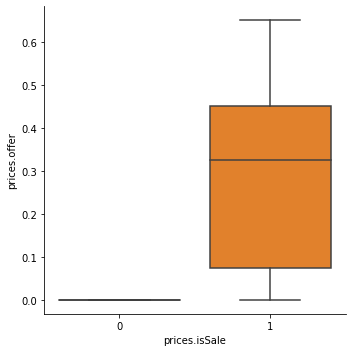

In [514]:
## Relationship between offer and issale
sns.catplot(x="prices.isSale", y="prices.offer", data=X_train, kind = "box")

- A discount (offer) is provided only when it is on sale. 
- This indicates that prices.isSale does not convey any new information and thus, it can be removed

In [515]:
features_remove.append('prices.isSale')

In [516]:
## Imputing values for merchant column

In [517]:
merchant_imputation = X_train[['prices.merchant', 'prices.sourceURLs']]
merchant_imputation['prices.sourceURLs'] = merchant_imputation['prices.sourceURLs'].str.extract(r'((?<=www.).+?(?=/))')
merchant_imputation['prices.merchant'] = merchant_imputation['prices.merchant'].str.lower()
#(merchant_imputation[~merchant_imputation['prices.merchant'].isnull()]['prices.merchant'] == merchant_imputation[~merchant_imputation['prices.merchant'].isnull()]['prices.sourceURLs']).all()
print("Unique values in merchant:", merchant_imputation['prices.merchant'].unique())
print("Unique values in source url:", merchant_imputation['prices.sourceURLs'].unique())


Unique values in merchant: [None 'backcountry.com' 'walmart.com' 'dailywear  sportswear corp.'
 'amazingbasics' 'slippers dot com' 'overstock.com' 'unbeatablesale'
 'tasharina corp' 'shoebuy.com']
Unique values in source url: ['kohls.com' 'backcountry.com' 'walmart.com' 'evo.com' 'overstock.com']



- Merchant contains the name of the third part seller from the e-commerce site if there is one. Company name from price source url contains only the e-commerce company name.

- We will fill all null values in merchant with e-commerce company name from source url. 

In [518]:
X_train['prices.merchant'] = X_train[['prices.merchant', 'prices.sourceURLs']].apply(lambda x: re.findall(r'((?<=www.).+?(?=/))', x['prices.sourceURLs'])[0] if pd.isnull(x['prices.merchant']) else x['prices.merchant'], axis = 1)
(X_train['prices.merchant'].isnull()).all()

False

In [519]:
## After dropping all the unwanted features

In [520]:
features_remove

['asins',
 'dimension',
 'ean',
 'prices.availability',
 'prices.condition',
 'prices.returnPolicy',
 'prices.shipping',
 'weight',
 'primaryCategories',
 'prices.currency',
 'dateAdded',
 'dateUpdated',
 'prices.dateAdded',
 'prices.dateSeen',
 'prices.amountMax',
 'prices.amountMin',
 'prices.sourceURLs',
 'sourceURLs',
 'imageURLs',
 'upc',
 'keys',
 'id',
 'sizes',
 'colors',
 'manufacturer',
 'manufacturerNumber',
 'categories',
 'prices.isSale']

In [521]:
X_train.columns

Index(['id', 'dateAdded', 'dateUpdated', 'asins', 'brand', 'categories',
       'primaryCategories', 'colors', 'dimension', 'ean', 'imageURLs', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'prices.amountMax',
       'prices.amountMin', 'prices.availability', 'prices.color',
       'prices.condition', 'prices.currency', 'prices.dateAdded',
       'prices.dateSeen', 'prices.isSale', 'prices.merchant', 'prices.offer',
       'prices.returnPolicy', 'prices.shipping', 'prices.size',
       'prices.sourceURLs', 'sizes', 'sourceURLs', 'upc', 'weight'],
      dtype='object')

In [525]:
X_train.drop(columns =features_remove, inplace = True)

After data cleaning and feature selection, the number of features is reduced from 34 to 6

In [526]:
X_train.describe(include = 'all')

,brand,name,prices.color,prices.merchant,prices.offer,prices.size
count,7000,7000,7000,7000,7000.000000,7000
unique,119,610,497,12,NaN,79
top,journee collection,Nike Flex Experience 6 Women's Running Shoes,Black,kohls.com,NaN,6
freq,1535,131,1399,6674,NaN,312
mean,NaN,NaN,NaN,NaN,0.005279,NaN
std,NaN,NaN,NaN,NaN,0.046926,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,NaN,0.000000,NaN
50%,NaN,NaN,NaN,NaN,0.000000,NaN
75%,NaN,NaN,NaN,NaN,0.000000,NaN


Let us change all categorical variables to lower case to avoid repeated counts during encoding

In [527]:
X_train = pd.concat([X_train.select_dtypes(include = 'object').apply(lambda x: x.str.lower()), X_train.select_dtypes(exclude = 'object')], axis=1)

In [528]:
X_train.describe(include = 'all')

,brand,name,prices.color,prices.merchant,prices.size,prices.offer
count,7000,7000,7000,7000,7000,7000.000000
unique,107,610,495,11,79,NaN
top,journee collection,nike flex experience 6 women's running shoes,black,kohls.com,6,NaN
freq,1535,131,1400,6674,312,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.005279
std,NaN,NaN,NaN,NaN,NaN,0.046926
min,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,0.000000


### Identifying duplicates

In [529]:
print("Is there any duplicate values? If so, how many?:", X_train[X_train.duplicated()].shape[0])

Is there any duplicate values? If so, how many?: 1169


In [530]:
### Remove duplicates from X and y data
y_train.drop(X_train[X_train.duplicated()].index, inplace = True)
X_train.drop_duplicates(inplace = True)

In [532]:
X_train.describe(include = 'all')

,brand,name,prices.color,prices.merchant,prices.size,prices.offer
count,5831,5831,5831,5831,5831,5831.000000
unique,107,610,495,11,79,NaN
top,journee collection,nike flex experience 6 women's running shoes,black,kohls.com,6,NaN
freq,1270,96,1145,5508,269,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.006337
std,NaN,NaN,NaN,NaN,NaN,0.051351
min,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,0.000000


In [533]:
print(f'Final shape of X {X_train.shape} and y {y_train.shape}')

Final shape of X (5831, 6) and y (5831,)


#### EDA and  Visualization

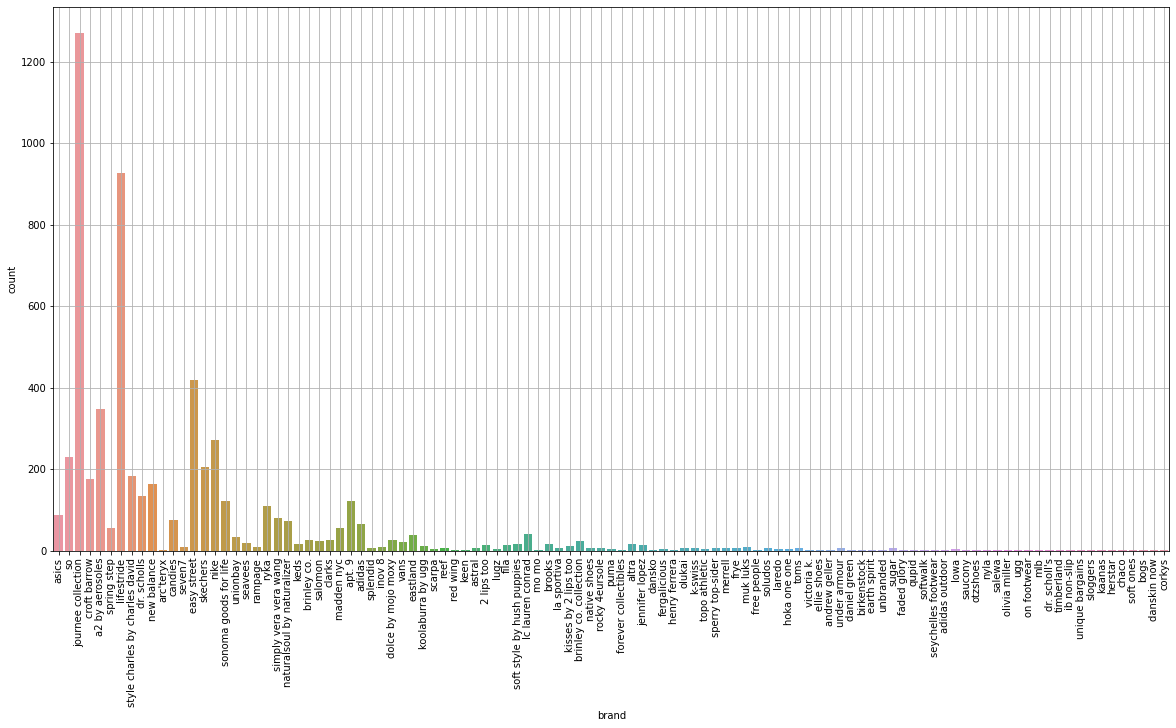

In [535]:
## Which brand occur more in our training dataset?
sns.countplot(x="brand",  data=X_train);
_ = plt.xticks(rotation = 90)
plt.gcf().set_size_inches(20, 10)
plt.grid()

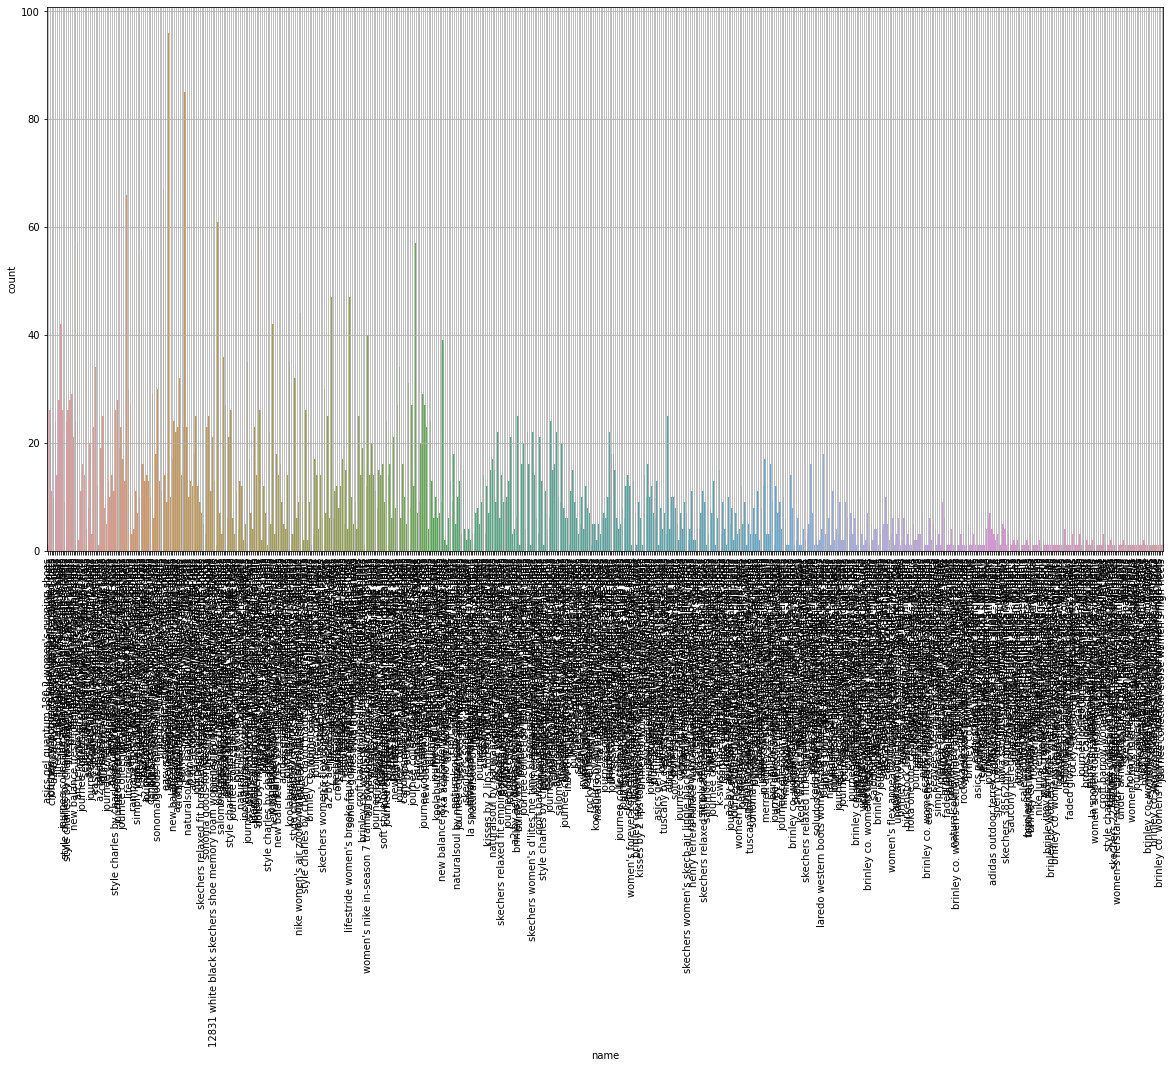

In [536]:
## Which model occur more in our training dataset?
sns.countplot(x="name",  data=X_train);
_ = plt.xticks(rotation = 90)
plt.gcf().set_size_inches(20, 10)
plt.grid()

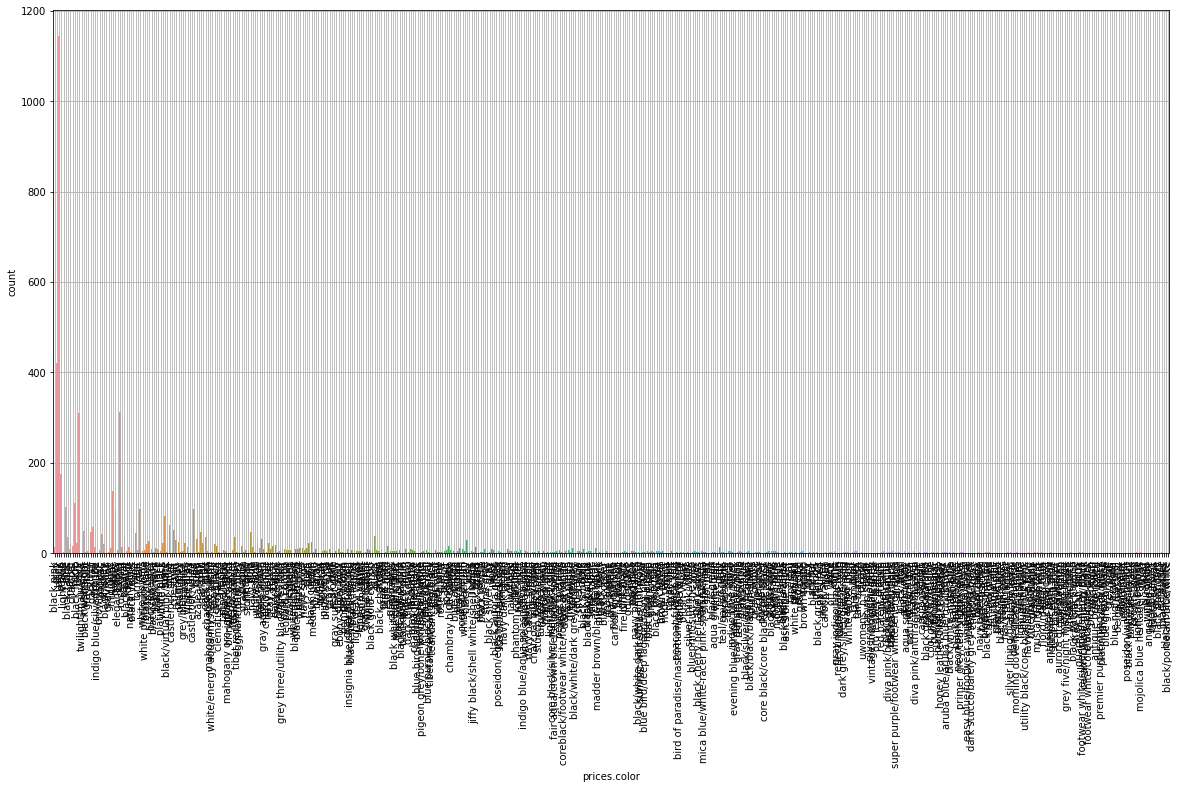

In [537]:
## Which color occur more in our training dataset?
sns.countplot(x="prices.color",  data=X_train);
_ = plt.xticks(rotation = 90)
plt.gcf().set_size_inches(20, 10)
plt.grid()

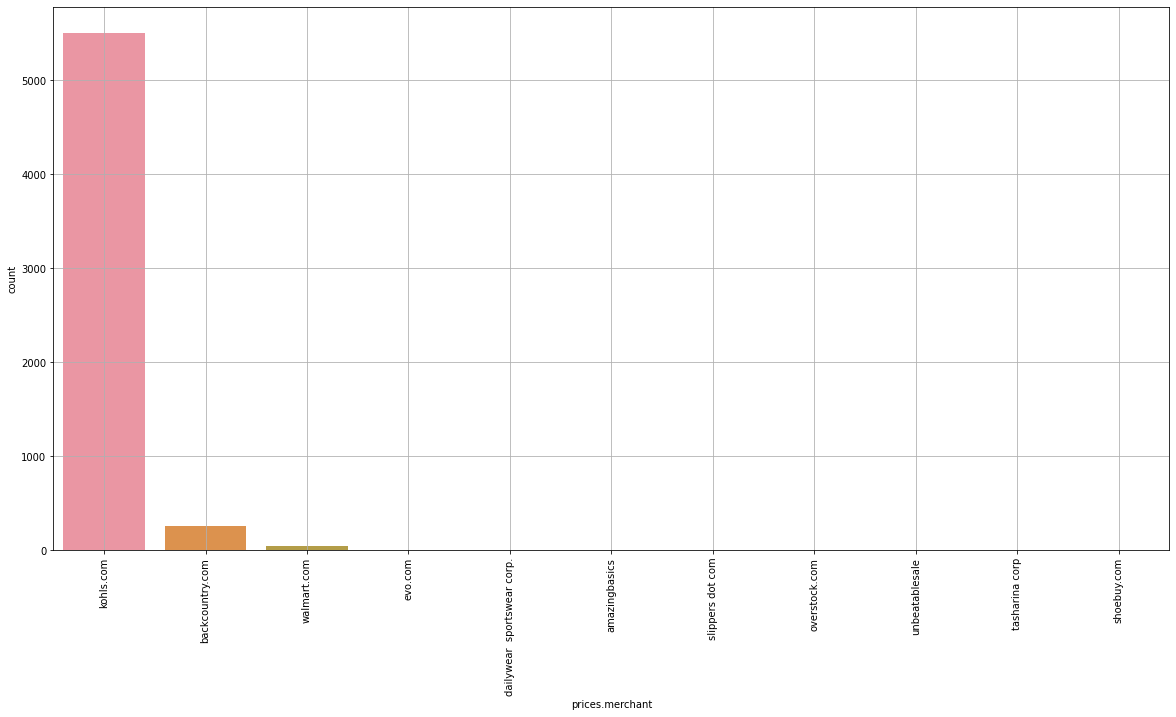

In [538]:
## Which merchant occur more in our training dataset?
sns.countplot(x="prices.merchant",  data=X_train);
_ = plt.xticks(rotation = 90)
plt.gcf().set_size_inches(20, 10)
plt.grid()

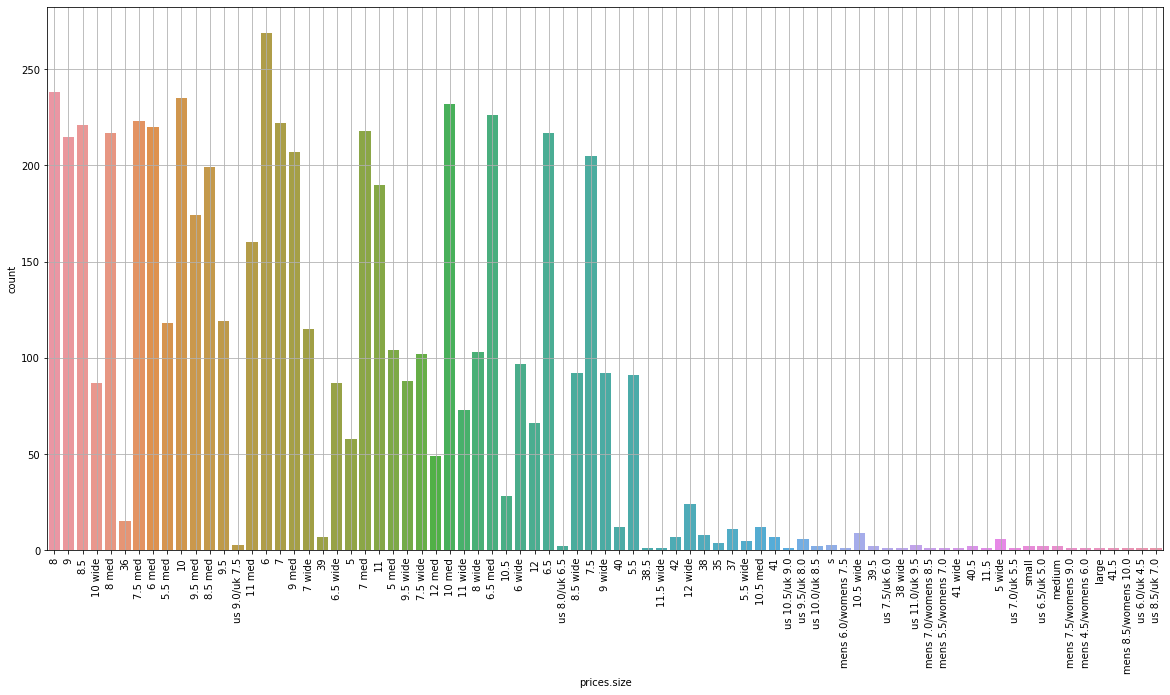

In [539]:
## Which shoe size occur more in our training dataset?
sns.countplot(x="prices.size",  data=X_train);
_ = plt.xticks(rotation = 90)
plt.gcf().set_size_inches(20, 10)
plt.grid()

(array([5.735e+03, 1.000e+00, 0.000e+00, 2.200e+01, 9.000e+00, 1.900e+01,
        1.800e+01, 1.000e+01, 1.300e+01, 4.000e+00]),
 array([0.   , 0.065, 0.13 , 0.195, 0.26 , 0.325, 0.39 , 0.455, 0.52 ,
        0.585, 0.65 ]),
 <a list of 10 Patch objects>)

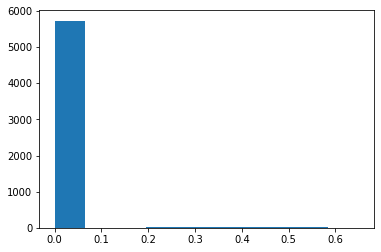

In [540]:
plt.hist(X_train['prices.offer'])

- For most of the shoes ther is no offer

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

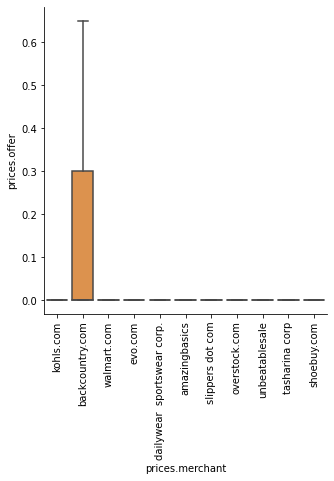

In [541]:
## Further exploration of prices.offer. Does all merchants provide sale offer?
sns.catplot(x="prices.merchant", y="prices.offer", data=X_train, kind = "box")
plt.xticks(rotation = 90)

In the data, only backcountry.com have sale offers
- select only backcountry data and see how it differs

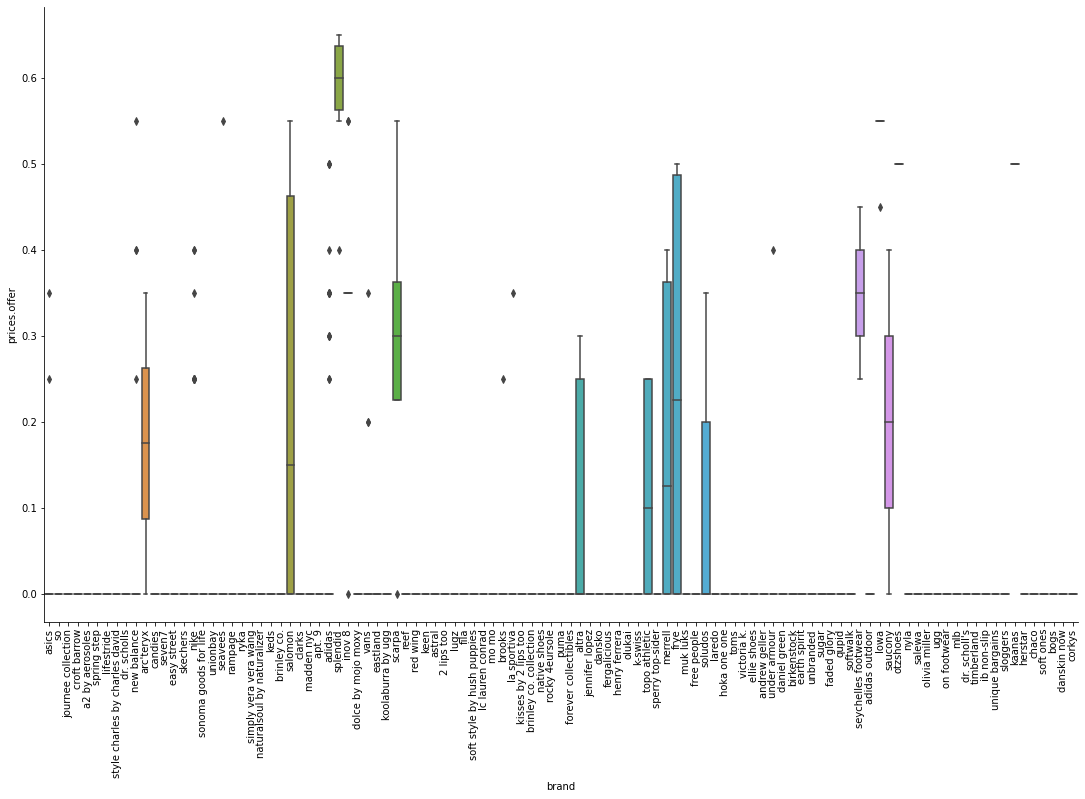

In [542]:
## Is this specific to any one brand? 
#plt.rcParams["figure.figsize"] = (10,20)
sns.catplot(x="brand", y="prices.offer", data=X_train, kind = "box")
_ = plt.xticks(rotation = 90)
plt.gcf().set_size_inches(20, 10)

- Shoes which are on sale hasve offer values. So, sale feature can be removed
- In the train data, only backcountry.com provides offers for their shoes. No other merchants provide offers. But this can vary with time
- Backcountry provides offers for many brands. Splendid branded shoes has the highest sale offer provided: average of 60%

### Feature Engineering
    - prices.size -- size of the shoe being sold


In [543]:
X_train['prices.size'].unique()

array(['8', '9', '8.5', '10 wide', '8 med', '36', '7.5 med', '6 med',
       '5.5 med', '10', '9.5 med', '8.5 med', '9.5', 'us 9.0/uk 7.5',
       '11 med', '6', '7', '9 med', '7 wide', '39', '6.5 wide', '5',
       '7 med', '11', '5 med', '9.5 wide', '7.5 wide', '12 med', '10 med',
       '11 wide', '8 wide', '6.5 med', '10.5', '6 wide', '12', '6.5',
       'us 8.0/uk 6.5', '8.5 wide', '7.5', '9 wide', '40', '5.5', '38.5',
       '11.5 wide', '42', '12 wide', '38', '35', '37', '5.5 wide',
       '10.5 med', '41', 'us 10.5/uk 9.0', 'us 9.5/uk 8.0',
       'us 10.0/uk 8.5', 's', 'mens 6.0/womens 7.5', '10.5 wide', '39.5',
       'us 7.5/uk 6.0', '38 wide', 'us 11.0/uk 9.5',
       'mens 7.0/womens 8.5', 'mens 5.5/womens 7.0', '41 wide', '40.5',
       '11.5', '5 wide', 'us 7.0/uk 5.5', 'small', 'us 6.5/uk 5.0',
       'medium', 'mens 7.5/womens 9.0', 'mens 4.5/womens 6.0', 'large',
       '41.5', 'mens 8.5/womens 10.0', 'us 6.0/uk 4.5', 'us 8.5/uk 7.0'],
      dtype=object)

Shoe sizes are reported in all different format. Mens/womens; small/medium/large, numbers, etc

In [544]:
## Does brands follow different sizing format? For example, which brand follow mens/womens format?
X_train[X_train['prices.size'] == 'mens 5.5/womens 7.0']

,brand,name,prices.color,prices.merchant,prices.size,prices.offer
9980,vans,vans ultrarange gore shoe - women's,black,backcountry.com,mens 5.5/womens 7.0,0.0


In [545]:
## Does Vans report its shoe size only in Mens/women's format?
df[df['brand'] =='Vans']['prices.size']

9863     Mens 7.0/Womens 8.5
9865     Mens 7.5/Womens 9.0
9866    Mens 8.5/Womens 10.0
9868     Mens 4.5/Womens 6.0
9869     Mens 6.0/Womens 7.5
9980     Mens 5.5/Womens 7.0
Name: prices.size, dtype: object

Vans brand uses the size format "Mans/womens" for all their shoes in this dataset

#### Fixing size feature
Let us convert all sizes to one format

- **remove men's sizes**: This prediction is only on women's shoes
- **convert all sizes to US size**: Convert everything to one unit - US size. Remove UK size and convert European to US - webscrape conversion table and use it
- **convert wide and med?**: Should wide and medium be another column?

In [546]:
## User defined functions to convert European sizes to US size. 
## EUR - US conversion table webscraped from 
## https://en.wikipedia.org/wiki/Shoe_size; table name: European shoe size conversion

def get_data_from_wiki(url, table_class = "wikitable sortable", table_no = 4):
    """Returns the requested table from the HTML parsed contents of a webpage
    url = link to the page where conversion table is present
    table_class = css class name of the table
    table_no = Number of the requested table in table class
    """
    soup = BeautifulSoup(requests.get(url).content, 'html.parser')
    table = soup.find_all('table', class_ = table_class)[table_no]
    return table

def get_eur_us_convertion(bs_table):
    '''Returns the EUR-US shoe conversion table as a pandas dataframe'''
    size_convert = {}
    for i, row in enumerate(bs_table.find_all('tr')):
        size_convert[i] = [text.strip() for j in row for text in j if text.strip() != '']
    size_convert_df = pd.DataFrame.from_dict(size_convert, orient = 'index')
    size_convert_df.rename(columns=size_convert_df.iloc[0], inplace = True)
    size_convert_df.drop(size_convert_df.index[0], inplace = True)
    return size_convert_df.astype(float)


In [547]:
def fix_shoe_size(x):
    '''Returns the shoe size in numerical format'''
    if "men" in x:
        return re.findall( r'[0-9]*.[0-9]$',x)[0]
    elif "us" in x:
        return re.findall( r'(?<=us )[0-9]*.[0-9](?=/)',x)[0]
    elif "small" in x:
        return "s"
    elif "medium" in x:
        return "m"
    elif "large" in x:
        return "l"
    if x.split()[0] in eur_us_conv:
        try: 
            return eur_us_conv[x.split()[0]] + " " + x.split()[1]
        except:
            return eur_us_conv[x.split()[0]]
    if "." not in x.split()[0]:
        try:
            return x.split()[0] + ".0" + " " + x.split()[1]
        except IndexError:
            return x.split()[0] + ".0"
    else:
        return x

In [549]:
# Web scrape EUR - US conversion table and save that information in a dictionary names eur_us_conv
page = get_data_from_wiki("https://en.wikipedia.org/wiki/Shoe_size")
eur_us_convt = get_eur_us_convertion(page)
eur_us_convt.set_index('EUR', inplace = True)
eur_us_conv = eur_us_convt.to_dict()['US women']

### Preprocess of data for train and test

1. Feature elimination
2. Prices.offer: Convert None to 0.0 and divide the rest by 100
3. prices.merchant: fill na with values from prices.source -- regexed
4. lower case all object types
5. convert shoe size to US size format
6. Convert all categorical feature values to lower case
7. normalize

In [556]:
#preprocess of test data

## Get the final list of columns
narrowed_features = list(X_train.columns)

# prices.merchant preprocessing: Pull regexed data from sourceURL for empty values
X_test['prices.merchant'] =  X_test[['prices.sourceURLs','prices.merchant']].apply(lambda x: re.findall(r'((?<=www.).+?(?=/))', x['prices.sourceURLs'])[0] if pd.isnull(x['prices.merchant']) else x['prices.merchant'], axis =1)

# prices.offer preprocessing: Add 0 for null values and fraction for values already present
X_test['prices.offer'] = X_test['prices.offer'].apply(lambda x: 0.0 if pd.isnull(x) else float(x[:2])/100)

## Convertion of shoe size to US size format
X_train['prices.size'] = X_train['prices.size'].apply(fix_shoe_size)
X_test['prices.size'] = X_test['prices.size'].apply(fix_shoe_size)

## Convert all categorical features to lowercase 
X_test_obj_types = X_test[narrowed_features].select_dtypes(include='object').apply(lambda x: x.str.lower(), axis =1)
X_test = pd.concat([X_test_obj_types, X_test[narrowed_features].select_dtypes(exclude='object')],axis =1)

## X_test data after preprocessing
X_test[narrowed_features].select_dtypes(include='object')

,brand,name,prices.color,prices.merchant,prices.size
6252,journee collection,journee collection issey women's high heels,gray,kohls.com,9.0
4684,fila,fila classic canvas women's casual shoes,gray white,kohls.com,7.0
1731,jennifer lopez,jennifer lopez cinnabar women's d'orsay flats,red,kohls.com,8.0
4742,a2 by aerosoles,a2 by aerosoles first love women's dress wedges,black,kohls.com,5.5 med
4521,lifestride,lifestride lively women's high heels,black micro,kohls.com,10.0 med
...,...,...,...,...,...
8014,nike,nike flex experience 6 women's running shoes,black aurora green,kohls.com,6.5
1074,so,so blog women's wedge ankle boots,brown,kohls.com,8.5 med
3063,dr. scholls,dr. scholl's dakota women's wedge ankle boots,black,kohls.com,8.5 wide
6487,journee collection,journee collection ela women's wedge ankle boots,stone,kohls.com,6.5


### Exploration of target variable

In [557]:
y_train.describe(percentiles = [.25, .5, .75, 0.85, 0.9, 0.95, 0.97])

count    5831.000000
mean       60.221646
std        19.422365
min         5.415000
25%        49.990000
50%        56.240000
75%        66.865000
85%        74.495000
90%        79.990000
95%        90.000000
97%       107.210000
max       359.950000
Name: average_price, dtype: float64

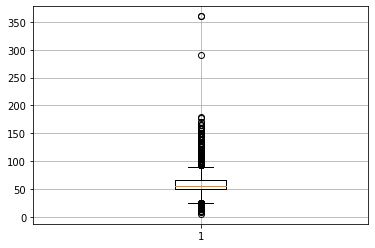

In [558]:
plt.boxplot(y_train)
plt.grid()
#plt.gcf().set_size_inches(4, 4)
#np.mean(y_train)

- Mean price of the shoes is USD60.2, but there are ~% of shoes have prices > $300

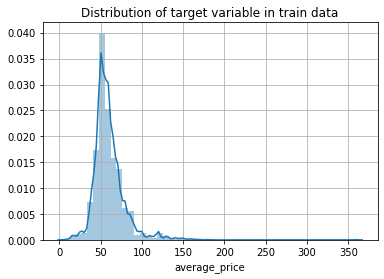

In [559]:
## Viewing the density plot
sns.distplot(y_train)
plt.title("Distribution of target variable in train data")
plt.grid()

### Preprocessing of target variable
Since target variable has outliers (skewed distribution), we can try bringing it to a less skewed by performing log transformation


Types of transformations on target variable 
    - minmax
    - log transform

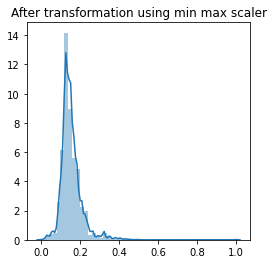

In [560]:
##Transformation of target variable
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

# minmax scaler
target_transform = MinMaxScaler()
target_transform.fit(y_train.values.reshape(-1, 1))
sns.distplot(target_transform.transform(y_train.values.reshape(-1, 1)))
#y_test_trans = target_transform.transform(y_test.values.reshape(-1, 1))

plt.title("After transformation using min max scaler")
#sns.distplot(y_train_trans)
plt.gcf().set_size_inches(4, 4)
plt.show()

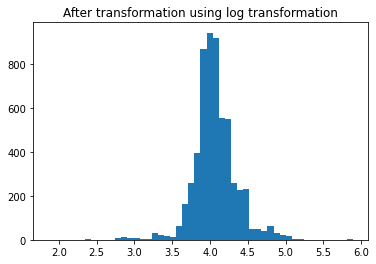

In [561]:
## Log transformer
plt.title("After transformation using log transformation")
plt.hist(np.log1p(y_train), bins =50)
#plt.gcf().set_size_inches(4, 4)
plt.show()

- Compared to all the transformations, log transformation seems to be less skewed and thus, it will be used for modelling

In [562]:
## Transformation of y

from sklearn.preprocessing import FunctionTransformer

#target_transform = FunctionTransformer(np.log1p, inverse_func = (np.exp)-1, validate=True)
target_transform = FunctionTransformer(np.log1p, inverse_func = None, validate=True)
target_transform.fit(y_train.values.reshape(-1, 1))
y_train_trans = target_transform.transform(y_train.values.reshape(-1, 1))
y_test_trans = target_transform.transform(y_test.values.reshape(-1, 1))

### Data Pipeline
    - Separate numerical and categorical features
    - Perform one hot encoding on categorical features
    - Perform standardization on numerical features
    - Combine the numerical and categorical features 

In [564]:
### Data transformation classes and functions
class ColumnsSelector(BaseEstimator, TransformerMixin):
    '''Class object to seperate numerical and categorical features to perform different types of
    preprocessing/feature engineering on numerical and categorical features'''

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y=None):
        try:
            X[self.attribute_names].shape[1]
            return X[self.attribute_names].values
        except IndexError:
            return X[self.attribute_names].values.reshape(-1,1)
        
        
# class shoe_size_convert(BaseEstimator, TransformerMixin):
#     '''Class object to convert shoe size to US shoe size format'''

#     def __init__(self, attribute_names):
#         self.attribute_names = attribute_names
    
#     def fit(self, X, y = None):
#         return self
    
#     def transform(self, X, y=None):
#         try:
#             X[self.attribute_names].shape[1]
#             return X[self.attribute_names].values
#         except IndexError:
#             return X[self.attribute_names].values.reshape(-1,1)

In [565]:
from sklearn.preprocessing import QuantileTransformer

#List of categorical feature names
cat_attributes = narrowed_features[:-1]
#List of numerical feature names
num_attributes = narrowed_features[-1] 

### Defining pipeline

## Pipeline for categorical variables
pipeline_cat = Pipeline([('attributes',ColumnsSelector(cat_attributes)),
                         ('onehotencoding', OneHotEncoder(handle_unknown='ignore'))])#,                         

## Pipeline for numberical variables
pipeline_num = Pipeline([('attributes',ColumnsSelector(num_attributes)),
                        ('standardization', StandardScaler(with_mean = False))])   

## Pipleine for combinging numerical and categorical variables
pipeline_features = FeatureUnion(transformer_list=[("categorical_features", pipeline_cat),
                                               ("numerical_feature", pipeline_num)])

In [566]:
train_data = pipeline_features.fit_transform(X_train, y_train)
test_data = pipeline_features.transform(X_test)

### Modelling of data


In [567]:
## Defining performance metric
def spot_check_model(model, trainx, trainy, score = 'neg_mean_squared_error'):
    '''Returns the mean CV score of given model. Performs cross validation with 5 splits with 3 repeats'''
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    model_score = cross_val_score(model, trainx, trainy, scoring = score, cv=cv)
    return model_score

def grid_search_cv(model, params, trainx, trainy):
    '''Performs gridsearch in the model for the given hypermaters with 5-fold CV and returns
    the best score and the fitted model best hyperparameters'''
    grid_cv = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv = 5, return_train_score = True)
    grid_cv.fit(trainx,trainy)
    return grid_cv, grid_cv.best_score_

def pipe_grid_search_results(model, train_x_data, y_train, test_x_data, y_test):
#def pipe_grid_search_results(classifier, test_x_data, y_test):
    '''Returns the value of the following metrics on test data: MSE, MAE and R2'''
    model.fit(train_x_data, y_train)
    preds = model.predict(test_x_data)
    print("Mean squared error of Test data:", mean_squared_error(y_test, preds))
    print("Mean absolute error of Test data:", mean_absolute_error(y_test, preds))
    print("R-squared score of Test data:", r2_score(y_test, preds))
    return None

def model_evaluation(model, parameters, trainx, trainy, testx, testy):
    '''Returns MSE on train and cross-validated data by evaluating the given model with the 
    given parameters using grid search. The best hyperparameter from grid search is used to check 
    the metrics on test data and the following metrics are returned for test data: MSE, MAE, R2'''
    fit, score= grid_search_cv(model, parameters, trainx, trainy)
    print("Results:")
    print("Mean squared error of train data: ",(-1)*fit.cv_results_['mean_train_score'][fit.best_index_])
    print("Mean squared error of CV data: ",(-1)*fit.cv_results_['mean_test_score'][fit.best_index_])
    print("Best hyperparameter:", fit.best_params_)
    pipe_grid_search_results(fit, trainx, trainy, testx, testy)
    return fit  

#### Model evaluated:
    1. Dummy (mean) model - For benchmarking
    2. Simple linear regression
    3. KNN
    4. Linear SVM
    5. Non-linear SVM
    6. Random Forest

1. Dummy (mean) model - For benchmarking

In [568]:
### Baseline dummy model: Predicts the mean price of y_train as ouput for any query
dr = DummyRegressor()
parameters = {'strategy': ['mean', 'median']}
model_evaluation(dr, parameters, train_data, y_train, test_data, y_test)


Results:
Mean squared error of train data:  377.15349265160773
Mean squared error of CV data:  377.2480534666171
Best hyperparameter: {'strategy': 'mean'}
Mean squared error of Test data: 373.1059321891707
Mean absolute error of Test data: 12.55592338163837
R-squared score of Test data: -2.1045338510550238e-05


GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']},
             return_train_score=True, scoring='neg_mean_squared_error')

The dummy model above (mean model) provides the baseline values for mean squared error and mean absolute error. These values will be used as benchmark to compare results from meaningful models.

2. Linear regression

In [569]:
## 1. Linear regression
lr = LinearRegression()
parameters = {'fit_intercept': [True, False]}
lr_fit = model_evaluation(lr, parameters, train_data, y_train, test_data, y_test)

Results:
Mean squared error of train data:  19.815692619373024
Mean squared error of CV data:  44.760926224974604
Best hyperparameter: {'fit_intercept': True}
Mean squared error of Test data: 36.14559289620871
Mean absolute error of Test data: 4.175122546157511
R-squared score of Test data: 0.9031203996667625


Analysis of fitted parameters from linear regression

In [570]:
features = pipeline_features.get_params()['categorical_features']['onehotencoding'].categories_
features = np.hstack(features)
features = np.append(features, np.array(['prices.offer']))

In [571]:
lr_coefficients = pd.DataFrame(lr_fit.best_estimator_.coef_, features, columns=['Coefficient'])
lr_coefficients.sort_values(by = 'Coefficient')


,Coefficient
slippers dot com,-38.557269
new balance 247 classic shoes - women's,-38.347734
nike kawa slide womens style : 834588,-35.205375
toms,-34.738488
walmart.com,-32.682095
...,...
backcountry.com,41.641712
asics gel quantum 180 2 women's running shoes,52.110161
evo.com,54.668651
red wing harriet boots - women's,81.730853


Linear regression residual analysis: Distribution of residuals

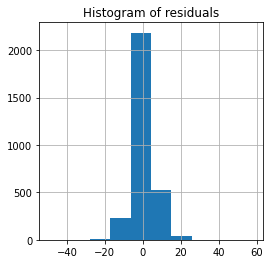

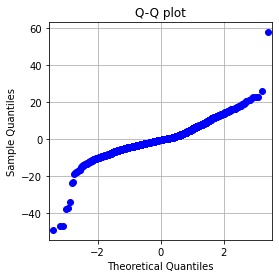

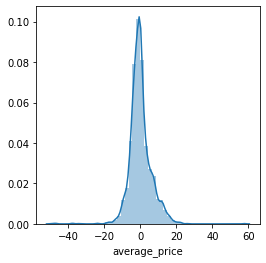

In [572]:
import statsmodels.api as sm
residual = y_test - lr_fit.predict(test_data)
plt.hist(residual)
plt.gcf().set_size_inches(4, 4)
plt.grid()
plt.title("Histogram of residuals")
prob = sm.ProbPlot(residual)
prob.qqplot()
plt.gcf().set_size_inches(4, 4)
plt.grid()
plt.title("Q-Q plot")
plt.show()
sns.distplot(residual)
plt.gcf().set_size_inches(4, 4)
#plt.hist(residual)

Linear regression residual analysis: Residual normally distributed? - Hypothesis testing

In [573]:
### Are the residuals are normally distributed?
### Hypothesis Testing for normal distribution -- Shapiro test
### Null hypothesis -- normally distributed; Alternate hypothesis -- Not normally distributed
### significance value: 0.5

from scipy.stats import shapiro
statistic, pval = shapiro(residual)
print(f"The test statistic from Shapiro test is {statistic}")
print(f"The p-value from Shapiro test is {pval}")
if pval > 0.5: 
    print("Fail to reject Null hypothesis: Residual distribution is normal")
else: 
    print("Reject Null hypothesis - Residual distribution is not normal")

The test statistic from Shapiro test is 0.9200723767280579
The p-value from Shapiro test is 3.1666710852627935e-37
Reject Null hypothesis - Residual distribution is not normal


Since the p-value is <0.5, we can reject the null hypothesis that the residuals are normal

Scatter plot of predicted value vs true value <br>
    - A 45deg sloped straigh line indicates perfect fit

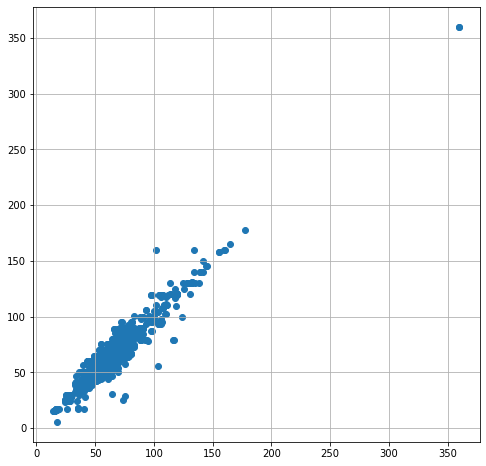

In [574]:
plt.scatter(lr_fit.predict(test_data), y_test)
plt.grid()
plt.gcf().set_size_inches(8, 8)
#plt.xlim(0,200)

Scatter plot of predicted value vs residual <br>
    - checking for heteroskedasticity

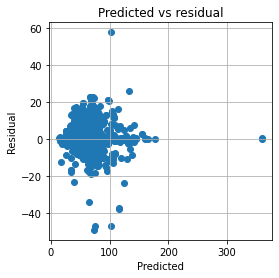

In [575]:
plt.scatter(lr_fit.predict(test_data), residual)
plt.xlabel("Predicted")
plt.ylabel("Residual")
#analysis = pd.DataFrame({'True': y_test, 'predict':lr_fit.predict(test_data)})
plt.grid()
plt.title("Predicted vs residual")
plt.gcf().set_size_inches(4, 4)
#plt.xlim(0,0.6)

Every model ('name') belongs to only one brand. Thus, brand feature is redundant. We can eliminate it

3. K-nearest neighbour regressor

In [576]:
## 3. K-nearest neighbour regressor
knn = KNeighborsRegressor()
parameters = {'n_neighbors': [3,5,7,9,11,13], 'p':[1,2]}
model_evaluation(knn, parameters, train_data, y_train, test_data, y_test)

Results:
Mean squared error of train data:  41.23701000677644
Mean squared error of CV data:  85.55049382766607
Best hyperparameter: {'n_neighbors': 3, 'p': 1}
Mean squared error of Test data: 75.72806590833332
Mean absolute error of Test data: 5.735748333333333
R-squared score of Test data: 0.7970290657487618


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13], 'p': [1, 2]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [577]:
from scipy.stats import anderson
result = anderson(residual)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 47.844
15.000: 0.575, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


4. Linear Support Vector Machines

In [578]:
## 3. Linear Support Vector Machines
svm_linear = SGDRegressor()
parameters = {'alpha': [.0001,.001,.01,.1,1,10], 'l1_ratio':[0,0.1,0.15], 'fit_intercept': [True, False]}
model_evaluation(svm_linear, parameters, train_data, y_train, test_data, y_test)


Results:
Mean squared error of train data:  29.87643965103275
Mean squared error of CV data:  61.45367329262824
Best hyperparameter: {'alpha': 0.0001, 'fit_intercept': True, 'l1_ratio': 0}
Mean squared error of Test data: 41.3402627678751
Mean absolute error of Test data: 4.5592546692066005
R-squared score of Test data: 0.8891973318538968


GridSearchCV(cv=5, estimator=SGDRegressor(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'l1_ratio': [0, 0.1, 0.15]},
             return_train_score=True, scoring='neg_mean_squared_error')

5. Non-Linear Support Vector Machines

In [581]:
## 4. Non-linear Support Vector Machine
svm_nonlinear = SVR()
parameters = {'C': [.1,1,10], 'kernel':['poly', 'rbf'],}
model_evaluation(svm_nonlinear, parameters, train_data, y_train, test_data, y_test)

Results:
Mean squared error of train data:  87.28139262968996
Mean squared error of CV data:  120.22660638396731
Best hyperparameter: {'C': 10, 'kernel': 'rbf'}
Mean squared error of Test data: 118.2258625549441
Mean absolute error of Test data: 5.342116520247974
R-squared score of Test data: 0.6831239054159595


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['poly', 'rbf']},
             return_train_score=True, scoring='neg_mean_squared_error')

6. Random Forest

In [582]:
## 5. Random Forest
rf = RandomForestRegressor()
parameters = {'n_estimators': [100, 200], 'max_depth':[2,5], 'max_features':['auto','log2']}
model_evaluation(rf, parameters, train_data, y_train, test_data, y_test)

Results:
Mean squared error of train data:  174.49031196868435
Mean squared error of CV data:  185.34398604217523
Best hyperparameter: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
Mean squared error of Test data: 172.01246070547606
Mean absolute error of Test data: 9.849161786366261
R-squared score of Test data: 0.5389618177426223


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 5], 'max_features': ['auto', 'log2'],
                         'n_estimators': [100, 200]},
             return_train_score=True, scoring='neg_mean_squared_error')

Summary from all the models tried

- Non-linear (non-linear SVM) and non-parametric - RF model have relatively higher train error:  it does not fit the training data well
- Linear regression, SVM linear and KNN (non-parametric) models have the lowest train error
- From this we can assume that the data might be linear and work with linear models
- In all the models, the CV and test error is higher than the train --> overfitting --> high variance: Let us try to reduce the overfitting by adding more complexity to the model -- adding L1 and L2 regularization
- Also, try fitting transformed target variable

In [583]:
### Modelling of data with transformed target variable

In [584]:
lr = LinearRegression()
parameters = {'fit_intercept': [True, False]}
lr_fit = model_evaluation(lr, parameters, train_data, y_train_trans, test_data, y_test_trans)

Results:
Mean squared error of train data:  0.005106324658601608
Mean squared error of CV data:  0.011063484916775675
Best hyperparameter: {'fit_intercept': True}
Mean squared error of Test data: 0.009050314304041315
Mean absolute error of Test data: 0.06867016181676902
R-squared score of Test data: 0.8881911866930864


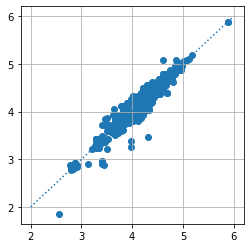

In [639]:
plt.scatter(lr_fit.predict(test_data), y_test_trans)
plt.grid()
plt.gcf().set_size_inches(4, 4)
plt.plot([2, 6], [2, 6], ':')

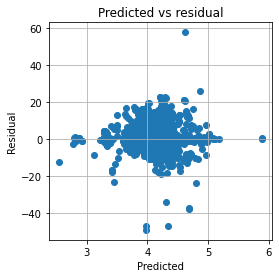

In [587]:
plt.scatter(lr_fit.predict(test_data), residual)
plt.xlabel("Predicted")
plt.ylabel("Residual")
#analysis = pd.DataFrame({'True': y_test, 'predict':lr_fit.predict(test_data)})
plt.grid()
plt.title("Predicted vs residual")
plt.gcf().set_size_inches(4, 4)
#plt.xlim(0,0.6)

In [588]:
## 3. K-nearest neighbour regressor
knn = KNeighborsRegressor()
parameters = {'n_neighbors': [3,5,7,9,11,13], 'p':[1,2]}
knn_fit = model_evaluation(knn, parameters, train_data, y_train_trans, test_data, y_test_trans)

Results:
Mean squared error of train data:  0.009882675564727697
Mean squared error of CV data:  0.02020288986331146
Best hyperparameter: {'n_neighbors': 3, 'p': 1}
Mean squared error of Test data: 0.018155702931029215
Mean absolute error of Test data: 0.09323490394968052
R-squared score of Test data: 0.7757019777131087


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13], 'p': [1, 2]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [589]:
## 3. Linear Support Vector Machines
svm_linear = SGDRegressor()
parameters = {'alpha': [.0001,.001,.01,.1,1,10], 'l1_ratio':[0,0.1,0.15], 'fit_intercept': [True, False]}
svm_lin_fit = model_evaluation(svm_linear, parameters, train_data, y_train_trans, test_data, y_test_trans)


Results:
Mean squared error of train data:  0.07441087354812248
Mean squared error of CV data:  0.08567210623838442
Best hyperparameter: {'alpha': 0.0001, 'fit_intercept': True, 'l1_ratio': 0.15}
Mean squared error of Test data: 0.07575697478398849
Mean absolute error of Test data: 0.15629477674432524
R-squared score of Test data: 0.06408803431973409


GridSearchCV(cv=5, estimator=SGDRegressor(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'l1_ratio': [0, 0.1, 0.15]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [590]:
## 4. Non-linear Support Vector Machine
svm_nonlinear = SVR()
parameters = {'C': [.1,1,10], 'kernel':['poly', 'rbf'],}
svm_nonlin_fit = model_evaluation(svm_nonlinear, parameters, train_data, y_train_trans, test_data, y_test_trans)

Results:
Mean squared error of train data:  0.006014574930516398
Mean squared error of CV data:  0.016022015556614887
Best hyperparameter: {'C': 10, 'kernel': 'rbf'}
Mean squared error of Test data: 0.01232663633229321
Mean absolute error of Test data: 0.0887125748112888
R-squared score of Test data: 0.8477150589384328


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['poly', 'rbf']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [607]:
rf = RandomForestRegressor()
parameters = {'n_estimators': [100, 200], 'max_depth':[2,5], 'max_features':['auto','log2']}
rf_fit = model_evaluation(rf, parameters, train_data, y_train_trans, test_data, y_test_trans)

Results:
Mean squared error of train data:  0.04506623751406954
Mean squared error of CV data:  0.047420750380249135
Best hyperparameter: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
Mean squared error of Test data: 0.04762850561322907
Mean absolute error of Test data: 0.16683711568214935
R-squared score of Test data: 0.41159096653484484


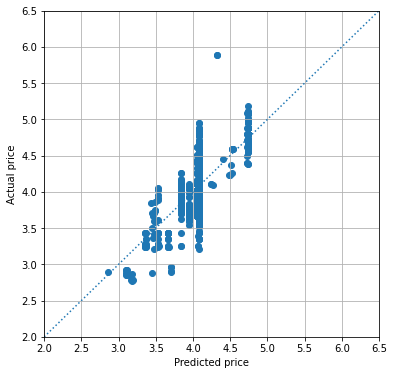

In [638]:
plt.scatter(rf_fit.predict(test_data), y_test_trans)
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.ylim(2,6.5)
plt.xlim(2,6.5)
plt.grid()
plt.gcf().set_size_inches(6, 6)
plt.plot([2, 6.5], [2, 6.5], ':')

### Modelling of data with transformed target variable and regularization

In [592]:
## Ridge regression to reduce overfitting of the model
from sklearn.linear_model import Ridge
rr = Ridge()
parameters = {'fit_intercept': [True, False], 'alpha':[1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0 ]}
rr_fit = model_evaluation(rr, parameters, train_data, y_train_trans, test_data, y_test_trans)

Results:
Mean squared error of train data:  0.0051390228788114325
Mean squared error of CV data:  0.011071338765922754
Best hyperparameter: {'alpha': 0.1, 'fit_intercept': True}
Mean squared error of Test data: 0.009143822943542032
Mean absolute error of Test data: 0.06891250720522246
R-squared score of Test data: 0.8870359682481479


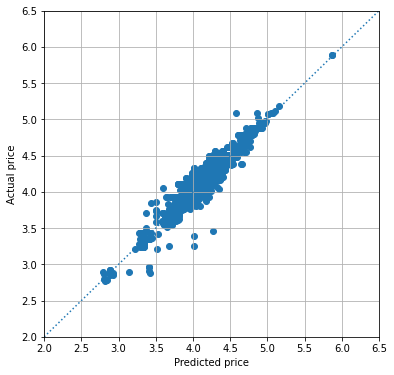

In [634]:
# Predicted data vs test data
plt.scatter(rr_fit.predict(test_data), y_test_trans)
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.ylim(2,6.5)
plt.xlim(2,6.5)
plt.grid()
plt.gcf().set_size_inches(6, 6)
plt.plot([2, 6.5], [2, 6.5], ':')

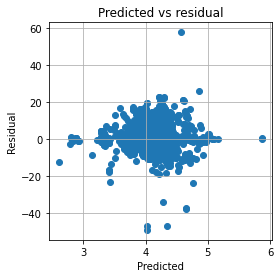

In [598]:
# Predicted data vs residual

plt.scatter(rr_fit.predict(test_data), residual)
plt.xlabel("Predicted")
plt.ylabel("Residual")
#analysis = pd.DataFrame({'True': y_test, 'predict':lr_fit.predict(test_data)})
plt.grid()
plt.title("Predicted vs residual")
plt.gcf().set_size_inches(4, 4)
#plt.xlim(0,0.6)

In [595]:
from sklearn.linear_model import Lasso
lassor = Lasso()
parameters = {'fit_intercept': [True, False], 'alpha':[1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0 ]}
lassor_fit = model_evaluation(lassor, parameters, train_data, y_train_trans, test_data, y_test_trans)

Results:
Mean squared error of train data:  0.036501346137971194
Mean squared error of CV data:  0.038234968866088175
Best hyperparameter: {'alpha': 0.001, 'fit_intercept': True}
Mean squared error of Test data: 0.03730057773109637
Mean absolute error of Test data: 0.13909547265719688
R-squared score of Test data: 0.5391835916777088


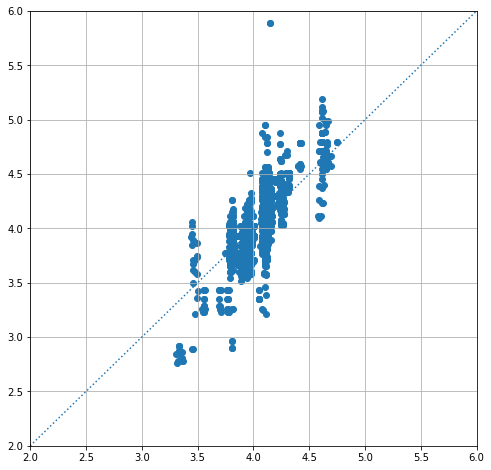

In [636]:
# Predicted data vs test data
plt.scatter(lassor_fit.predict(test_data), y_test_trans)
plt.grid()
plt.ylim(2,6)
plt.xlim(2,6)
plt.gcf().set_size_inches(8, 8)
plt.plot([2, 6], [2, 6], ':')

In [596]:
from sklearn.linear_model import ElasticNet
elr = ElasticNet()
parameters = {'fit_intercept': [True, False], 'alpha':[1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0 ],
             'l1_ratio':[0, 0.2,0.4,0.6,0.8,1]}
elr_fit = model_evaluation(elr, parameters, train_data, y_train_trans, test_data, y_test_trans)

Results:
Mean squared error of train data:  0.010592614402573725
Mean squared error of CV data:  0.01585150246879593
Best hyperparameter: {'alpha': 0.001, 'fit_intercept': True, 'l1_ratio': 0}
Mean squared error of Test data: 0.014058399459734059
Mean absolute error of Test data: 0.08593091609527757
R-squared score of Test data: 0.8263206218279593


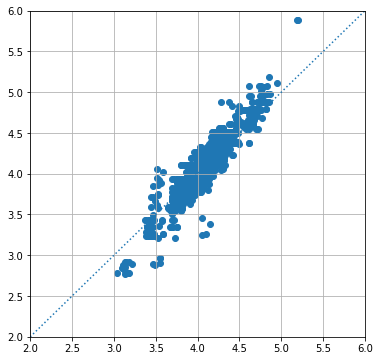

In [637]:
plt.scatter(elr_fit.predict(test_data), y_test_trans)
plt.grid()
plt.xlim(2, 6)
plt.ylim(2,6)
plt.gcf().set_size_inches(6, 6)
plt.plot([2, 6], [2, 6], ':')

### Finalized model - Linear regression with Ridge regularization

Linear regression model with Ridge regularization

- MSE: 0.009 
- MAE: 0.068
- R2: 0.887

In [623]:
# Generate a random number and use that as index to validate the model
 ind = np.random.randint(0,3000, size =1)

array([1506])

In [628]:
X_test.iloc[1506,:]

brand                                           journee collection
name               journee collection rory women's mary jane heels
prices.color                                                 white
prices.merchant                                          kohls.com
prices.size                                                   11.0
prices.offer                                                     0
Name: 6162, dtype: object

In [627]:
test_data[1506].toarray()
y_test_trans[1506]

array([4.11070992])

In [629]:
rr_fit.predict(test_data[1506].toarray())

array([[4.1420617]])